In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

In [3]:
df_2020 = pd.read_csv('../../dobrano_2020_pre_preprocessado.csv', sep=';', low_memory=False, encoding='latin1')
df_2020.shape

(454432, 20)

In [4]:
df_2020.head()

,idade,sexo,raca_cor,escolaridade,local_ocorrencia,codmunocor,teve_assistencia_medica,dia_nasc,mes_nasc,ano_nasc,dia_obito,mes_obito,ano_obito,faixa_etaria,estado,codigo_estado,categoria_causa_basica,capitulo_causa_basica,grupo_ocupacao,codigo_grupo_ocupacao
0,68,M,BRANCA,EF_I,DOMICILIO,316930,NAO,10,5.0,1951.0,25,1,2020,"(65, 70]",MG,31,Sint sinais e achad anorm ex clín e laborat,18.0,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...,9.0
1,53,M,PRETA,EF_I,DOMICILIO,316930,NAO,16,3.0,1966.0,25,1,2020,"(50, 55]",MG,31,Sint sinais e achad anorm ex clín e laborat,18.0,"TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA P...",6.0
2,82,F,BRANCA,EF_I,HOSPITAL,316930,NaN,10,7.0,1937.0,14,1,2020,"(80, 85]",MG,31,Doenças do aparelho digestivo,11.0,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...,9.0
3,73,F,BRANCA,EF_I,HOSPITAL,316930,SIM,2,11.0,1946.0,20,1,2020,"(70, 75]",MG,31,Doenças do aparelho respiratório,10.0,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...,9.0
4,60,M,BRANCA,SUPERIOR_C,HOSPITAL,316930,SIM,12,9.0,1959.0,26,1,2020,"(55, 60]",MG,31,Algumas doenças infecciosas e parasitárias,1.0,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES ...,2.0


In [5]:
df = df_2020[:1000]

#### DELETANDO COLUNAS QUE NÃO SERÃO USADAS

In [6]:
df = df.drop(columns=['idade', 'codmunocor', 'dia_nasc', 'mes_nasc', 'dia_obito', 'ano_obito', 'estado', 
                      'categoria_causa_basica', 'grupo_ocupacao'])

In [13]:
df.isnull().sum()

sexo                         0
raca_cor                    57
escolaridade               127
local_ocorrencia             0
teve_assistencia_medica    302
ano_nasc                    22
mes_obito                    0
faixa_etaria                47
codigo_estado                0
capitulo_causa_basica        0
codigo_grupo_ocupacao        0
dtype: int64

In [10]:
df['codigo_grupo_ocupacao'] = df.codigo_grupo_ocupacao.fillna(10)

In [12]:
df = df.loc[df['capitulo_causa_basica'].notnull()]

#### TRANSFORMANDO DADOS EM NUMÉRICOS

In [14]:
df['raca_cor'] = df['raca_cor'].replace(['BRANCA', 'PRETA', 'AMARELA', 'PARDA', 'INDIGENA'], [1, 2, 3, 4, 5])

In [15]:
df['escolaridade'] = df['escolaridade'].replace(
                                          ['SEM', 'EF_I', 'EF_II', 'EM', 'SUPERIOR_I', 'SUPERIOR_C', 'I'],
                                        [0, 1, 2, 3, 4, 5, 9]
                                         )

In [16]:
df['local_ocorrencia'] = df['local_ocorrencia'].replace(['HOSPITAL', 'OES', 'DOMICILIO', 'VIAP', 'OUTROS', 'I'],
                                            [1, 2, 3, 4, 5, 9]
                                         )

In [17]:
df['teve_assistencia_medica'] = df['teve_assistencia_medica'].replace(['SIM', 'NAO', 'I'], [1, 2, 9]
                                             )

In [18]:
df['sexo'] = df['sexo'].replace(['M', 'F', 'I'], [1, 2, 0]) 

In [19]:
df.head(8)

,sexo,raca_cor,escolaridade,local_ocorrencia,teve_assistencia_medica,ano_nasc,mes_obito,faixa_etaria,codigo_estado,capitulo_causa_basica,codigo_grupo_ocupacao
0,1,1.0,1.0,3,2.0,1951.0,1,"(65, 70]",31,18.0,9.0
1,1,2.0,1.0,3,2.0,1966.0,1,"(50, 55]",31,18.0,6.0
2,2,1.0,1.0,1,NaN,1937.0,1,"(80, 85]",31,11.0,9.0
3,2,1.0,1.0,1,1.0,1946.0,1,"(70, 75]",31,10.0,9.0
4,1,1.0,5.0,1,1.0,1959.0,1,"(55, 60]",31,1.0,2.0
5,1,4.0,1.0,1,1.0,1964.0,1,"(50, 55]",31,10.0,7.0
6,2,4.0,1.0,3,NaN,1973.0,1,"(45, 50]",23,2.0,6.0
7,1,1.0,5.0,4,2.0,1974.0,1,"(40, 45]",51,18.0,10.0


#### SEPRANDO DATASETS

In [31]:
for i in df.columns:
    df = df.loc[df[i].notnull()]

In [32]:
df.isnull().sum()

sexo                       0
raca_cor                   0
escolaridade               0
local_ocorrencia           0
teve_assistencia_medica    0
ano_nasc                   0
mes_obito                  0
faixa_etaria               0
codigo_estado              0
capitulo_causa_basica      0
codigo_grupo_ocupacao      0
dtype: int64

In [33]:
df['raca_cor'] = df['raca_cor'].astype('int') 

In [34]:
df['escolaridade'] = df['escolaridade'].astype('int')

In [35]:
df['teve_assistencia_medica'] = df['teve_assistencia_medica'].astype('int')

In [36]:
df['capitulo_causa_basica'] = df['capitulo_causa_basica'].astype('int')

In [37]:
df['codigo_grupo_ocupacao'] = df['codigo_grupo_ocupacao'].astype('int')

In [47]:
df = df.drop(columns='faixa_etaria')

In [48]:
y = df['capitulo_causa_basica']

In [49]:
type(y)

pandas.core.series.Series

In [50]:
x = df.drop(columns=['capitulo_causa_basica'])

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

In [52]:
x_train.shape

(357, 9)

In [53]:
y_test.shape

(176,)

In [80]:
rf = RandomForestClassifier(n_estimators = 100, bootstrap = True,
#                                max_features = 'sqrt',
                            max_depth = 3, random_state = 42
                           )

rf.fit(x_train, y_train)

preds = rf.predict(x_test)

print(np.sqrt(mean_squared_error(y_test, preds)))

score = accuracy_score(y_test, preds)

score

5.557038943374593


0.3181818181818182

In [81]:
conf_mtrx = confusion_matrix(y_test, preds)

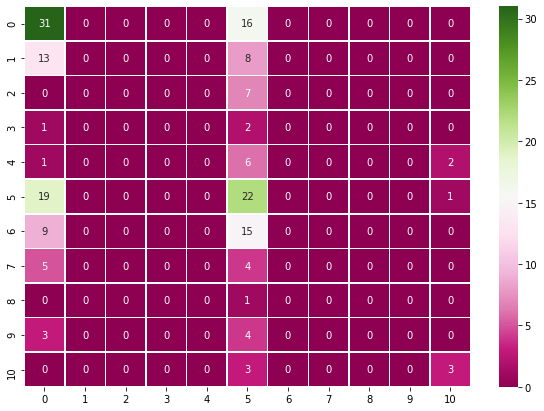

In [82]:
plt.figure(figsize = (10,7))
matrix = sns.heatmap(conf_mtrx, annot=True, fmt=".0f", linewidths=.5, cmap="PiYG") #Making a Heatmap out of the matrix
plt.show()

In [83]:
class_report = classification_report(y_test, preds)

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
print(class_report)

              precision    recall  f1-score   support

           1       0.38      0.66      0.48        47
           2       0.00      0.00      0.00        21
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         9
           9       0.25      0.52      0.34        42
          10       0.00      0.00      0.00        24
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         7
          18       0.50      0.50      0.50         6

    accuracy                           0.32       176
   macro avg       0.10      0.15      0.12       176
weighted avg       0.18      0.32      0.23       176



In [85]:
estimator = rf.estimators_[3]

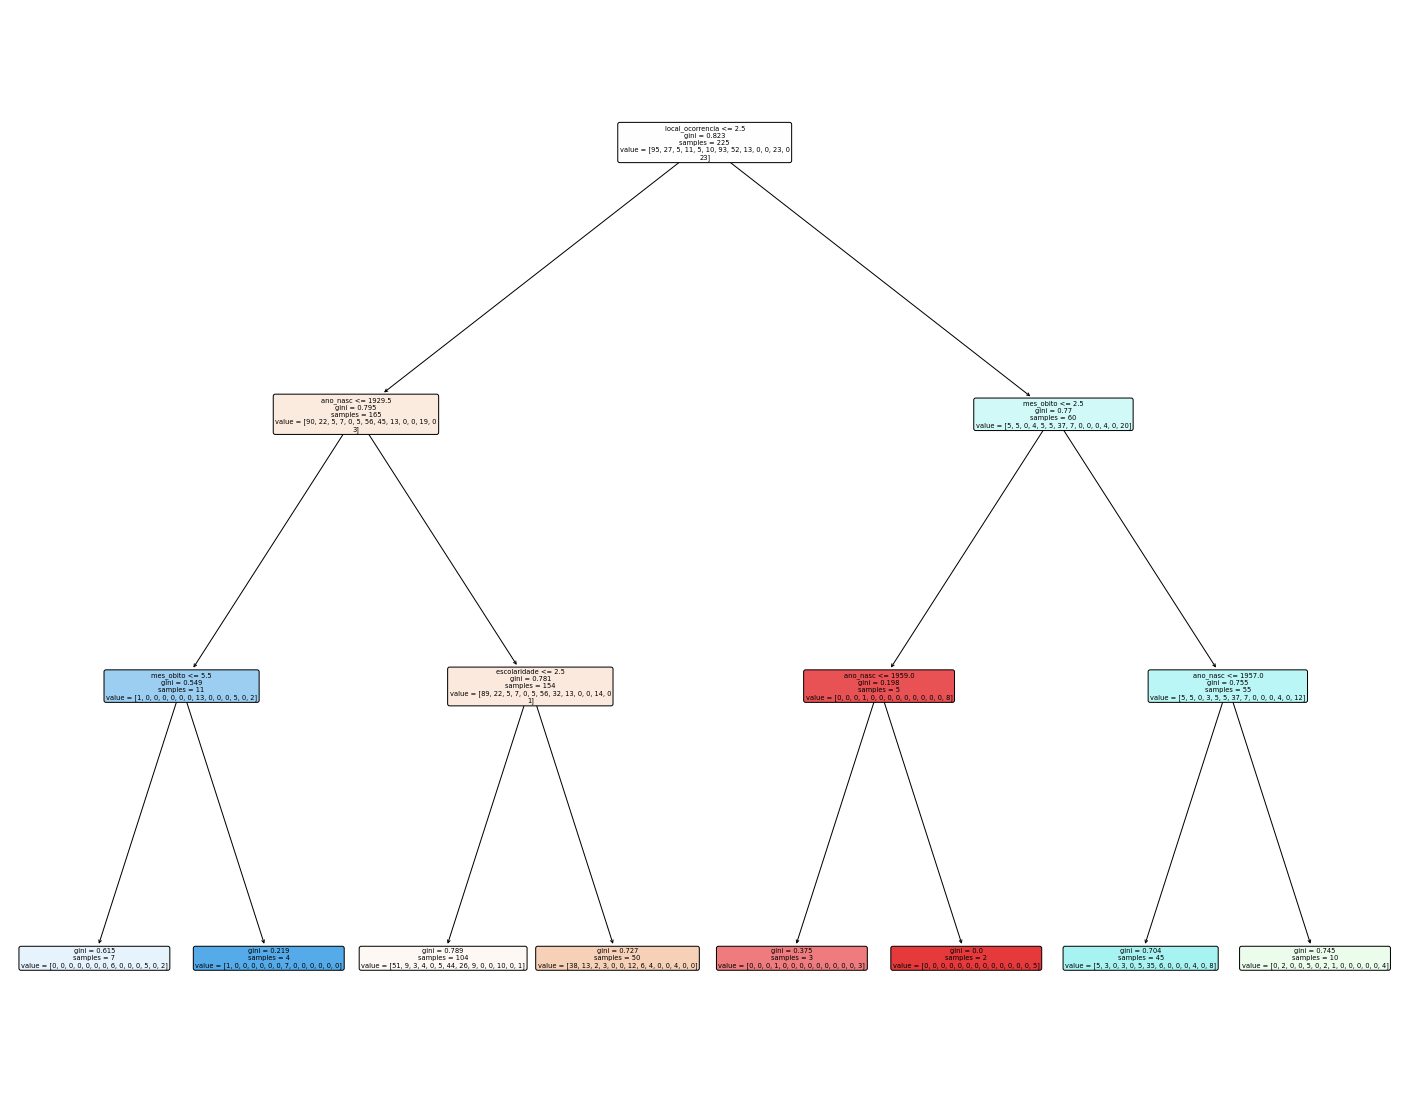

In [86]:
fig = plt.figure(figsize=(25, 20))
plot_tree(rf.estimators_[0], 
          feature_names=x.columns,
#           class_names=, 
          filled=True, impurity=True, 
          rounded=True)
plt.show()

In [87]:
fig.savefig('random_forest.png', quality=95, optimizer=True, dpi=100)

<ipython-input-87-52e6ec2cbcb8>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('random_forest.png', quality=95, optimizer=True, dpi=100)
<ipython-input-87-52e6ec2cbcb8>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimizer" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('random_forest.png', quality=95, optimizer=True, dpi=100)
